# PIC 16A Group Mini-Project

## Group Contributions Statement

We, Jaya Ren and Melody Chan, are a group of 2. Both of us wrote the data acquisition and preparation. Jaya led the exploratory analysis and modeling for the decision tree classifier. Melody led the modeling for the multinomial logistic regression and wrote the discussion. 

## Preparing Data

### §0. Exploring Data

Let's begin by importing all the libraries we'll need, and by downloading the penguins dataset:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
penguins = pd.read_csv(url)
# shortern the species name
penguins["Species"] = penguins["Species"].str.split().str.get(0)
# show the first few rows of penguins dataset 
penguins.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [3]:
# drop the penguins with sex equals to a dot
penguins = penguins[penguins['Sex'] != '.'] 

To learn more about the relationships between penguin species and different features, we will write a function to see the different median values of different features among different species. We want to create a model that will utilize two quantitative features and one qualitative feature to predict a penguin's species. 

In [4]:
def penguin_summary_table(group_cols, value_cols):
    return penguins.groupby(group_cols)[value_cols].median().round(2)

In [5]:
penguin_summary_table(["Species", "Sex", "Island"], 
                      ["Culmen Length (mm)", "Body Mass (g)", 
                       "Culmen Depth (mm)", "Flipper Length (mm)"])

Culmen Length (mm)  Body Mass (g)  \
Species   Sex    Island                                         
Adelie    FEMALE Biscoe                  37.75         3375.0   
                 Dream                   36.80         3400.0   
                 Torgersen               37.60         3400.0   
          MALE   Biscoe                  40.80         4000.0   
                 Dream                   40.25         3987.5   
                 Torgersen               41.10         4000.0   
Chinstrap FEMALE Dream                   46.30         3550.0   
          MALE   Dream                   50.95         3950.0   
Gentoo    FEMALE Biscoe                  45.50         4700.0   
          MALE   Biscoe                  49.50         5500.0   

                            Culmen Depth (mm)  Flipper Length (mm)  
Species   Sex    Island                                             
Adelie    FEMALE Biscoe                 17.70                187.0  
                 Dream                  17.80                188.0  
                 Torgersen              17.45                189.0  
          MALE   Biscoe                 18.90                191.0  
                 Dream                  18.65                190.5  
                 Torgersen              19.20                195.0  
Chinstrap FEMALE Dream                  17.65                192.0  
          MALE   Dream                  19.30                200.5  
Gentoo    FEMALE Biscoe                 14.25                212.0  
          MALE   Biscoe                 15.70                221.0

As shown in the table, only Adelie penguins live on Torgersen island. On Biscoe island, there are Gentoo and Adelie penguins. On Dream island, there are Chinstrap and Adelie penguins. With respect to each species, the values for each feature for male and female don't differ too much, so sex is not a significant factor here. Therefore, `Island` is a better candidate of our model's qualitative feature. The culmen length of Adelie is significantly shorter than Chinstrap and Gentoo, and the body mass of Gentoo is significantly larger than Adelie and Chinstrap, so these two features might be good candidates for our model. 

Then, we create histograms to visualize how `Culmen Length (mm)`, `Body Mass (g)`, `Culmen Depth (mm)`, and `Flipper Length (mm)` values differ for each species of penguin in our data set.

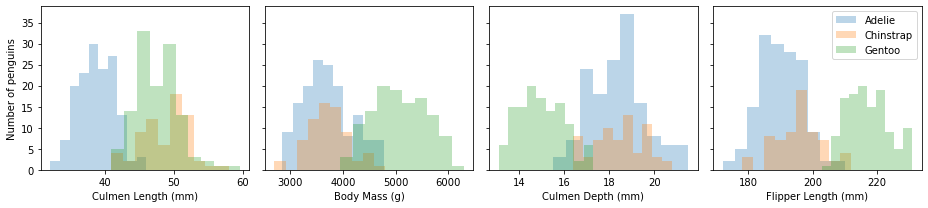

In [6]:
fig, ax = plt.subplots(1,4, figsize = (13,3), sharey = True)
ax[0].set(ylabel = "Number of penguins")
features = ["Culmen Length (mm)", "Body Mass (g)", 
            "Culmen Depth (mm)","Flipper Length (mm)"]

for i in range(0,len(features)):
    for s in penguins["Species"].unique():
        df = penguins[penguins["Species"] == s]
        ax[i].hist(df[features[i]], label = s, alpha = 0.3)
        ax[i].set(xlabel = features[i])
        
plt.tight_layout()
plt.legend()

From the histograms, values of body mass, culmen length, and flipper length for Chinstrap penguins don't differ much from those of Adelie penguins, but the culmen lengths for Chinstrap and Gentoo penguins are significantly different from those of Adelie penguins, so to distinguish Adelie penguins from Chinstrap and Gentoo penguins, `Culmen Length (mm)` is a good candidate for our model's first quantitative feature. Our second quantitative feature should be `Body Mass (g)`, `Culmen Depth (mm)`, or `Flipper Length (mm)`. Because the histograms indicates that Gentoo penguins stand out in terms of `Body Mass (g)`, `Culmen Depth (mm)`, and `Flipper Length (mm)`, only of one of these features should be chosen as our second quantitative feature.

### §1. Splitting Data

We set our seed to 1000 to make sure we generate the same values every time.

In [7]:
np.random.seed(1000)

Our goal is to build a model that predicts the species of a penguin based on features in the penguins dataframe.  By splitting the date into training and test data, we hold out some data that we won't let our model see at first. This holdout data is testing data. The other data that we allow our model to see is called the training data. We split the dataframe into training and test data (80/20% of the rows).

In [8]:
# Split the data into training and test sets.
from sklearn.model_selection import train_test_split
train, test = train_test_split(penguins, test_size = 0.2)

### §2. Cleaning Data

Then, we create a function to clean our data. There is text data in our dataframe, such as `MALE` or `FEMALE`, for column `Sex`. We convert the `Sex`, `Island`, and `Species` text into numbers by encoding them as integers. For instance, `MALE` and `FEMALE` are now encoded as`1` and `0` respectively.

In [9]:
from sklearn import preprocessing

def clean_data(data):
    '''
    A function that encodes text data in "Sex","Island", and "Species" to integers.
    To be specific, this function encodes "FEMALE" as 0 and "MALE" as 1 for "Sex".
    For "Species", it encodes "Adelie Penguin (Pygoscelis adeliae)" as 0, 
    "Gentoo penguin (Pygoscelis papua)" as 2, 
    and "Chinstrap penguin (Pygoscelis antarctica)" as 1.
    For "Island", it encodes "Biscoe" as 0, "Dream" as 1, and "Torgersen" as 2.
    
    input: dataset
    
    output: a numpy array of the cleaned data and the name of columns
    '''
    # make copies of the given inputs using the .copy() method
    data_copy = data.copy()
    
    # encode the sex and the species of the penguins as integers
    le = preprocessing.LabelEncoder()
    data_copy['Sex'] = le.fit_transform(data_copy['Sex'])
    data_copy['Species'] = le.fit_transform(data_copy['Species'])
    data_copy['Island'] = le.fit_transform(data_copy['Island'])
    
    return(data_copy, list(data_copy.columns.values))

Next, we clean the data in the train and test sets.

In [10]:
clean_train, labels = clean_data(train)
clean_test, labels = clean_data(test)

In [11]:
# inspect the ouput 
clean_train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
271,PAL0809,52,2,Anvers,0,"Adult, 1 Egg Stage",N13A2,Yes,11/4/08,48.5,14.1,220.0,5300.0,1,8.39867,-26.79358,NaN
42,PAL0708,43,0,Anvers,1,"Adult, 1 Egg Stage",N27A1,Yes,11/19/07,36.0,18.5,186.0,3100.0,0,9.50772,-25.03492,NaN
132,PAL0910,133,0,Anvers,1,"Adult, 1 Egg Stage",N76A1,Yes,11/10/09,36.8,18.5,193.0,3500.0,0,8.98705,-25.57647,NaN
162,PAL0708,11,1,Anvers,1,"Adult, 1 Egg Stage",N68A1,Yes,11/28/07,46.6,17.8,193.0,3800.0,0,8.95063,-24.59897,NaN
96,PAL0809,97,0,Anvers,1,"Adult, 1 Egg Stage",N49A1,Yes,11/8/08,38.1,18.6,190.0,3700.0,0,8.10277,-26.50086,NaN


## Decision Tree Model

### §1. Selecting Features for Decision Tree Model

To determine which potential features to use in our model, we created a correlation heat map to examine the correlation between different features of our data frame.

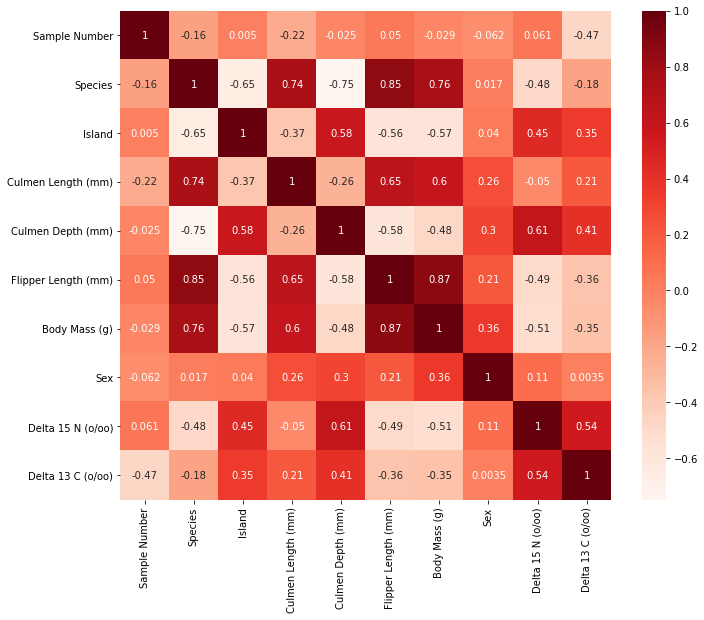

In [12]:
# correlation heat map
import seaborn as sns
plt.figure(figsize=(11,9))
cor = clean_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Then, we create a variable to determine which features are the most highly correlated with `Species`, our target variable.

In [13]:
#Correlation with output variable
cor_target = abs(cor["Species"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Species                1.000000
Island                 0.650317
Culmen Length (mm)     0.743650
Culmen Depth (mm)      0.747714
Flipper Length (mm)    0.850751
Body Mass (g)          0.760612
Name: Species, dtype: float64

For our decision tree model, we first pick the qualitative feature with highest correlation coefficient, which is `Island`. Now we select two quantitative features from `Culmen Length (mm)`, `Culmen Depth (mm)`, `Flipper Length (mm)` and `Body Mass (g)` since they have the highest correlation ccoefficients. By inspecting the heat map of correlation coefficients, we observe that `Culmen Length (mm)` is least correlated to `Island`, so we pick `Culmen Length (mm)` to be our second feature. Among `Culmen Depth (mm)`, `Flipper Length (mm)` and `Body Mass (g)`, `Culmen Depth (mm)` is least correlated to `Culmen Length (mm)`, so we pick `Culmen Depth (mm)` to be our third feature. 

Our feature selection using this correlation plot supports our previous analysis of selecting features. The above summary table indicated that `Island` is a better qualitative feature to use in our model than `Sex`. The histograms also supported the notion that `Culmen Depth (mm)` should be one of our model's quantitative features. From the correlation plot, we determine `Culmen Depth (mm)` as our third feature which supports our earlier theory that our second quantitative feature should be `Body Mass (g)`, `Culmen Depth (mm)`, or `Flipper Length (mm)`. Our earlier exploratory figures and analysis of the different features of penguins support our analysis for this correlation plot.

After selecting our features, we drop the na values in the training and testing data sets and split them each further into X and y (predictor variables and target variable). Our predictor variables for this decision tree model are `Culmen Length (mm)`,`Culmen Depth (mm)`, and `Island`. Our target variable is `Species`.  

In [14]:
clean_train1 = clean_train[["Culmen Length (mm)","Culmen Depth (mm)", 
                            "Island", "Species"]].dropna()
clean_test1 = clean_test[["Culmen Length (mm)","Culmen Depth (mm)", 
                          "Island", "Species"]].dropna()
X_train1  = clean_train1[["Culmen Length (mm)","Culmen Depth (mm)", "Island"]]
y_train1 = clean_train1[["Species"]]
X_test1 = clean_test1[["Culmen Length (mm)","Culmen Depth (mm)", "Island"]]
y_test1 = clean_test1[["Species"]]
labels = ["Culmen Length (mm)","Culmen Depth (mm)", "Island"]

### §2. Decision Tree Modeling and Cross-Validation

We then create our decision tree classification model `T`. The optimal tree depth complexity tells us the best way to use "flow-chart" style reasoning to predict the target variable using our predictor variables. To estimate the optimal tree depth using cross-validation, we use a `for`-loop which trains a decision tree model of the given depth (from 1 to 30) and calculate its cross-validation score. Cross-validation uses an automated framework to help us get a better understanding of whether our model is overfitting. We want to avoid overfitting as it fits a machine learning model to perfectly fit the training data, but it performs poorly on our testing data. 

To visualize our cross-validation process, we create a plot with tree depth on its x-axis and cross-validation score on its y-axis. For each iteration, we compare the score to the best score we have so far, and update the best score and best max depth if the new score is better.

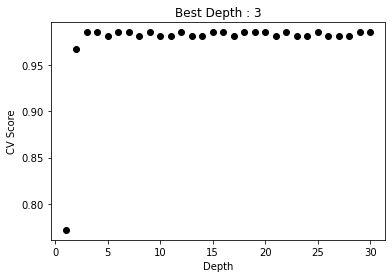

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn import tree

fig, ax = plt.subplots(1)

best_score = 0

for d in range(1,31):  # loop from 1 to 3
    T = tree.DecisionTreeClassifier(max_depth = d)   # decision tree model
    cv_score = cross_val_score(T, X_train1, y_train1, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")  # plot cv score v. depth
    if cv_score > best_score:   # compare each score to best score
        best_depth = d
        best_score = cv_score

l = ax.set(title = "Best Depth : " + str(best_depth),
       xlabel = "Depth", 
       ylabel = "CV Score")

This plot shows that our best max depth for our decision tree model is 3.

### §2. Evaluating Tree Model on Test Set

Now, we train a decision tree classification model `T` using the best max depth of 3. We also score the model against the test data. Our score for this model is about 98.55%.

In [16]:
T = tree.DecisionTreeClassifier(max_depth = best_depth)
T.fit(X_train1, y_train1)    # train model against test data
T.score(X_test1, y_test1)    # score model against test data

0.9855072463768116

We visualize our decision tree model below.

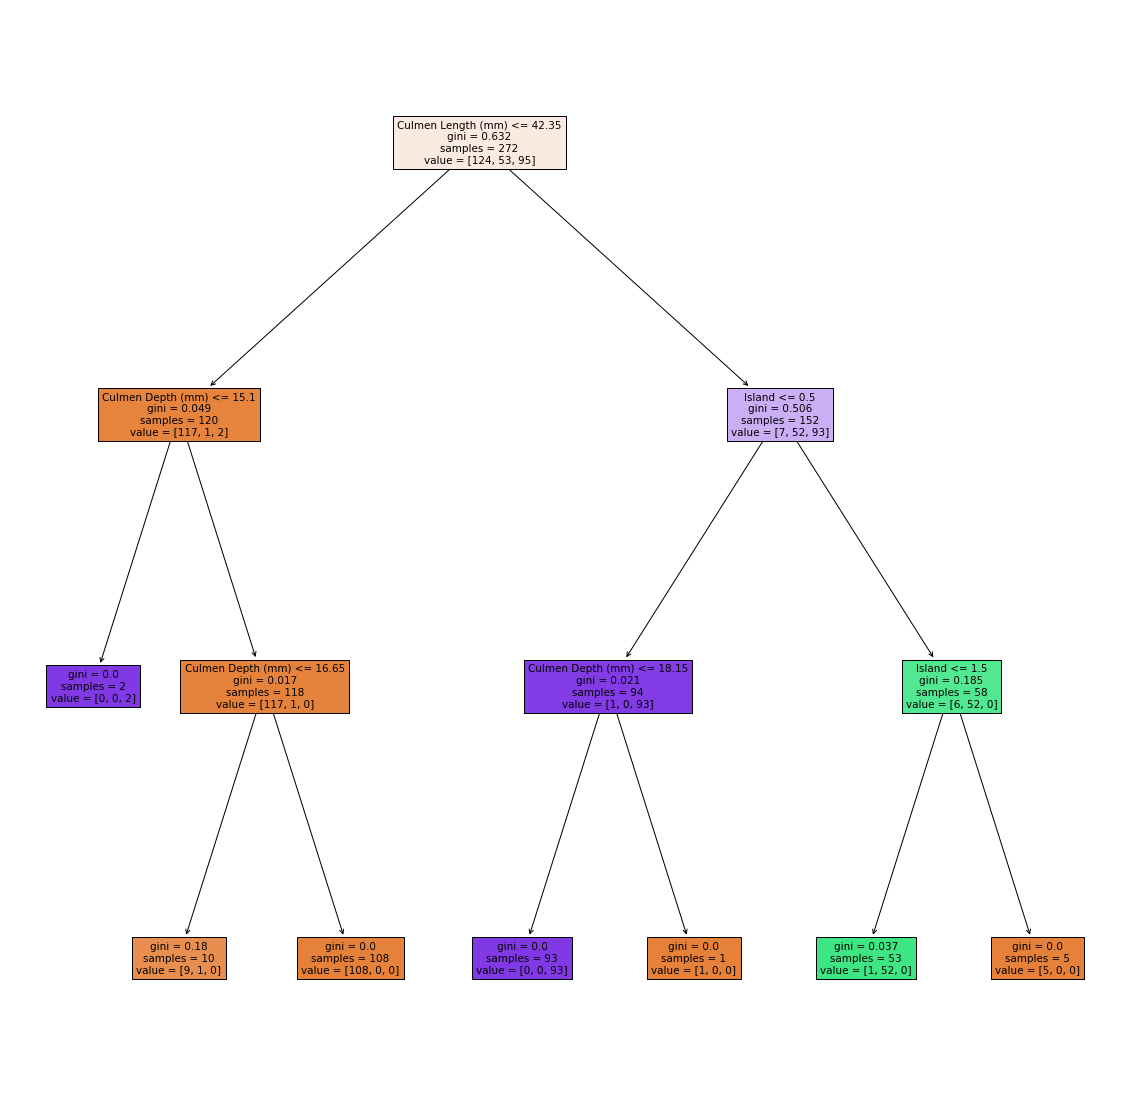

In [17]:
fig, ax = plt.subplots(1, figsize = (20, 20))
p = tree.plot_tree(T, filled = True, feature_names = labels)

This model first examines whether the penguin's `Culmen Length (mm) <= 42.35`. If so, the model then looks at the penguin's culmen depth. If not, the model looks at the penguin's island of residence. For instance, if a penguin's `Culmen Length (mm) > 42.35`, we look at the `Island`. If `Island <= 0.5`, then it resides on Biscoe Island and we then look at its culmen depth. If `Culmen Depth (mm) <= 18.15`, then it predicts the penguin to be a Gentoo penguin. 

### §3. Model Errors and Confusion Matrix for Decision Tree

To better understand where our decision tree model made errors, we first extract the predictions that our model makes using the testing data.

In [18]:
y_test_pred1 = T.predict(X_test1)
y_test_pred1

array([2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 0, 1, 0, 2, 2, 0, 1, 2, 2, 2, 2, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2,
       2, 0, 0, 2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 2, 2,
       2, 1, 2])

Then we create a confusion matrix to visualize our model's predictions against truth. 

In [19]:
from sklearn.metrics import confusion_matrix
c1 = confusion_matrix(y_test1, y_test_pred1)
c1

array([[26,  1,  0],
       [ 0, 15,  0],
       [ 0,  0, 27]], dtype=int64)

From the confusion matrix, we observe from the large numbers on the diagonal that the model is usually right, but there is one case in our testing data when the model is not. The `0,1`th entry of the confusion matrix gives the number of times that the model predicted a penguin to be `1`, or Chinstrap, when the penguin was in fact `0`, or Adelie. The model incorrectly predicts one penguin to be Chinstrap when it's actually Adelie. 

Boolean indexing allows us to conveniently extract all of the incorrectly-classified penguins in our testing data set.

In [20]:
mistakes1 = X_test1[y_test1['Species'] != y_test_pred1]
mistake_labels1 = y_test1[y_test1['Species'] != y_test_pred1]
mistake_preds1 = y_test_pred1[y_test1['Species'] != y_test_pred1]

mistake_preds1, mistake_labels1

(array([1]),
     Species
 43        0)

Only one penguin is predicted incorrectly in the testing data. Our model predicted a penguin to be a Chinstrap penguin when it actually was an Adelie penguin. This result respects the confusion matrix above.

### §4. Decision Regions for Decision Tree Model

Decision regions visualize how our classifier model performs on a large set of penguins and how the classifier makes its decisions. The contours along which different decision regions meet are called decision boundaries. We set our X-values to be `Culmen Length (mm)` and `Culmen Depth (mm)`. Our y-values are the `Species`. We fit this into our decision tree classifier model.

In [21]:
le = preprocessing.LabelEncoder()
penguins['label'] = le.fit_transform(penguins['Species'])

penguins = penguins.dropna(subset=['Culmen Length (mm)', 'Culmen Depth (mm)'])
X = penguins[['Culmen Length (mm)', 'Culmen Depth (mm)']]
y = penguins['label']

In [22]:
T = tree.DecisionTreeClassifier(max_depth = 3)
T.fit(X, y)

DecisionTreeClassifier(max_depth=3)

We create a function that will plot three separate plots for each possible value of our qualitative predictor variable, `Species`. The horizontal and vertical axes are the two quantitative predictor variables, `Culmen Length (mm)` and `Culmen Depth (mm)`.

In [23]:
def plot_regions_island(c):
    '''
    a function that creates decision regions of 
    'Species' using Culmen Length (mm) vs. Culmen 
    Depth (mm) plots for each possible value of
    'Island'
    
    input: classifier model
    
    output: plot with decision regions
    
    '''
    # defines a diction with keys being the name of the island
    # and values being the corresponding subset of the data frame
    d = {
        island_name : penguins[penguins["Island"] == island_name] 
        for island_name in penguins["Island"].unique()
    }
    
    
    # sets 'Culmen Length (mm)' as horizontal axis values
    # sets 'Culmen Depth (mm)' as vertical axis values
    # loops over each Island to create separate plots of decision regions
    for i in d.keys():
        df = d[i]
        x0 = df['Culmen Length (mm)']
        x1 = df['Culmen Depth (mm)']
        y  = df['label']
    
    # create a grid
        grid_x = np.linspace(x0.min(),x0.max(),501)
        grid_y = np.linspace(x1.min(),x1.max(),501)
        xx, yy = np.meshgrid(grid_x, grid_y)
    
    # extract model predictions, using the 
    # np.c_ attribute to join together the 
    # two parts of the grid. 
    # array.ravel() converts an multidimensional
    # array into a 1d array, and we use array.reshape()
    # to turn the resulting predictions p 
    # back into 2d
    
        XX = xx.ravel()
        YY = yy.ravel()
        XY = np.c_[XX, YY]
    
        p = c.predict(XY)
        p = p.reshape(xx.shape)
    
    # create the plot
        fig, ax = plt.subplots(1)
    
    # use contour plot to visualize the predictions
        ax.contourf(xx, yy, p, cmap = "jet", alpha = 0.2)
    
    # plot the data
        ax.scatter(x0, x1, c = y, cmap = "jet", vmin = 0, vmax = 2)
    
        ax.set(xlabel = "Culmen Length (mm)",
               ylabel = "Culmen Depth (mm)",
               title = i)
    

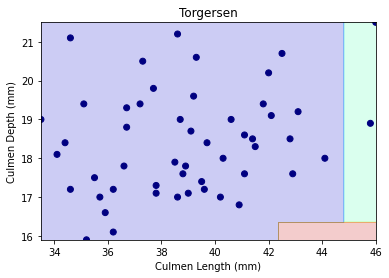

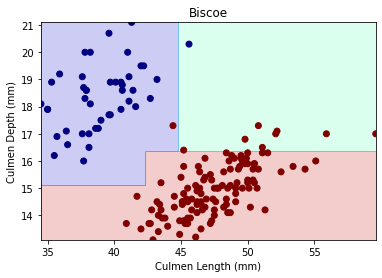

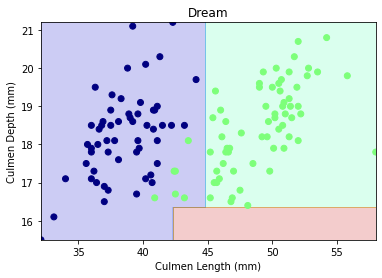

In [24]:
plot_regions_island(c = T)

As observed from the decision regions, the decision tree classifier model predicts the species correctly most of the time. Only Adelie penguins live on Torgersen Island. For the Torgersen Island, our model incorrectly predicts an Adelie penguin to be a Chinstrap penguin. On Biscoe Island, the model interprets a few Gentoo penguins as Adelie or Chinstrap. On Dream Island, the model incorrectly interprets a few Chinstrap penguins to be Adelie penguins.

## Multinomial Logistic Regression (MLR)

### §1. Selecting Features and Cross-Validation for MLR Model

Based upon the summary table, histograms, and correlation heat map above, we picked various features with high correlation to test different combinations of feature and determine the optimal complexity of the multinomial logistic regression model. First, we cleaned the data of any na values in our chosen potential features. We also split them each further into X and y (predictor variables and target variable). Our predictor variables for this decision tree model are `Culmen Length (mm)`,`Culmen Depth (mm)`, `Flipper Length (mm)`, `Body Mass (g)`, `Sex` and `Island`. Our target variable is `Species`.  

In [25]:
clean_train2 = clean_train[["Culmen Length (mm)","Culmen Depth (mm)", 
                            "Island", "Species", "Flipper Length (mm)", 
                            "Body Mass (g)", "Sex"]].dropna()
clean_test2 = clean_test[["Culmen Length (mm)","Culmen Depth (mm)", 
                          "Island", "Species", "Flipper Length (mm)",
                          "Body Mass (g)", "Sex"]].dropna()
X_train2 = clean_train2.drop(["Species"], axis = 1)
y_train2 = clean_train2[["Species"]]
X_test2 = clean_test2.drop(["Species"], axis = 1)
y_test2 = clean_test2[["Species"]]

Then, we create our Logistic Regression model.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

LR = LogisticRegression()
cross_val_score(LR, X_train2, y_train2, cv = 5).mean()

0.9741414141414142

We create a function to train and evaluate the model and cross-validate on various combinations of features to determine which combination yields the highest cross-validation score. As mentioned above, cross-validation helps us to prevent overfitting our model to the training data. 

In [27]:
def check_column_score(cols):
    """
    Trains and evaluates a model via cross-validation on the columns of the data
    with selected indices.
    
    Input: columns
    
    Output: cross-validation score
    """
    print("training with columns " + str(cols))
    return cross_val_score(LR, X_train2[cols], y_train2, cv = 5).mean()  

We then made different combinations of 3 features (2 quantitative and 1 qualitative) to help us determine which features to select for our multinomial logistic regression model. We use the `check_column_score` function on our combinations to determine which has the highest cross-validation score so that we can select our features for this model. 

In [28]:
# different combinations of 3 features (2 quantitative and 1 qualitative)
combos = [["Culmen Length (mm)","Culmen Depth (mm)", "Island"],   
          ["Flipper Length (mm)","Body Mass (g)", "Island"],
          ["Culmen Depth (mm)", "Island", "Body Mass (g)"],
          ["Flipper Length (mm)", "Body Mass (g)", "Sex"],
          ["Culmen Length (mm)", "Island", "Flipper Length (mm)"],
          ["Culmen Length (mm)","Sex", "Flipper Length (mm)"],
          ["Culmen Depth (mm)", "Sex", "Body Mass (g)"],
          ["Culmen Depth (mm)", "Island", "Flipper Length (mm)"]]

# checking CV score for each combo
for cols in combos: 
    x = check_column_score(cols)
    print("CV score is " + str(np.round(x, 3)))

training with columns ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island']
CV score is 0.978
training with columns ['Flipper Length (mm)', 'Body Mass (g)', 'Island']
CV score is 0.714
training with columns ['Culmen Depth (mm)', 'Island', 'Body Mass (g)']
CV score is 0.798
training with columns ['Flipper Length (mm)', 'Body Mass (g)', 'Sex']
CV score is 0.735
training with columns ['Culmen Length (mm)', 'Island', 'Flipper Length (mm)']
CV score is 0.945
training with columns ['Culmen Length (mm)', 'Sex', 'Flipper Length (mm)']
CV score is 0.908
training with columns ['Culmen Depth (mm)', 'Sex', 'Body Mass (g)']
CV score is 0.801
training with columns ['Culmen Depth (mm)', 'Island', 'Flipper Length (mm)']
CV score is 0.823


After checking the CV scores for different combinations, we found that the one with `Culmen Depth (mm)`, `Culmen Length (mm)`, and `Island` has the highest cross-validation score of 0.978. Thus, we select those features for our multinomial logistric regression model and put them as our predictor variables for both the training and testing data sets.

In [29]:
X_train2 = X_train2[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island']]
X_test2 = X_test2[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island']]

### §2. Evaluating MLR Model on Test Set

Now, we train our multinomial logistric regression model `LR` using features we selected. We also score the model against the testing data. Our score for this model is about 97.10%.

In [30]:
LR.fit(X_train2, y_train2)
LR.score(X_test2, y_test2)

0.9710144927536232

### §3. MLR Model Errors and Confusion Matrix

To better understand where our multinomial logistic regression model made errors, we first extract the predictions that our model makes using the testing data.

In [31]:
y_test_pred2 = LR.predict(X_test2)
y_test_pred2

array([2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 0, 1, 0, 2, 2, 0, 1, 2, 2, 2, 2, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 2,
       2, 0, 0, 2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2,
       2, 1, 2])

Then we create a confusion matrix to visualize our model's predictions against truth. 

In [32]:
c2 = confusion_matrix(y_test2, y_test_pred2)
c2

array([[26,  1,  0],
       [ 1, 14,  0],
       [ 0,  0, 27]], dtype=int64)

From the confusion matrix, we observe from the large numbers on the diagonal that the model is usually right, but there are two cases in our testing data when the model is not. The `0,1`th entry of the confusion matrix gives the number of times that the model predicted a penguin to be `1`, or Chinstrap, when the penguin was in fact `0`, or Adelie. The model incorrectly predicts one penguin to be Chinstrap when it's actually Adelie. The `1,0`th entry of the confusion matrix gives the number of times that the model predicted a penguin to be `0`, or Adelie, when the penguin was in fact `1`, or Chinstrap. The model also incorrectly predicts one penguin to be Adelie when it's actually Chinstrap. 

In [33]:
mistakes2 = X_test2[y_test2['Species'] != y_test_pred2]
mistake_labels2 = y_test2[y_test2['Species'] != y_test_pred2]
mistake_preds2 = y_test_pred2[y_test2['Species'] != y_test_pred2]

mistake_preds2, mistake_labels2

(array([1, 0]),
      Species
 73         0
 216        1)

Boolean indexing again helps us extract incorrectly-classified penguins. Two penguins are predicted incorrectly in the testing data. Our model predicted a penguin to be a Chinstrap penguin when it actually was an Adelie penguin. It also predicted a peguin to be an Adelie penguin when it actually was a Chinstrap penguin. This result respects the confusion matrix above.

### §4. MLR Model Decision Trees

Using the `plot_regions_island` function defined above, we plot the decision regions for our multinomial logistic regression model to visualize how our model performs on a large set of penguins and how the model makes its decisions.

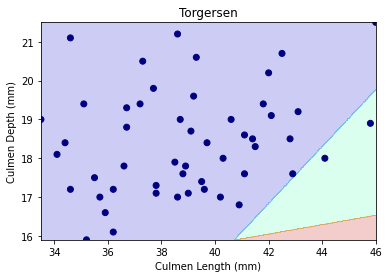

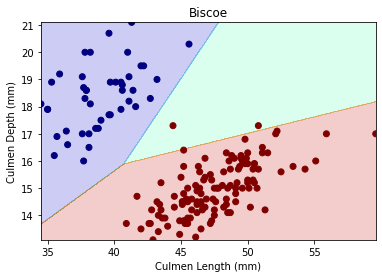

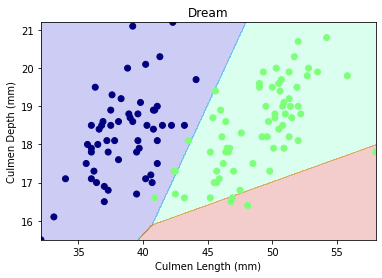

In [34]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X, y)
plot_regions_island(LR)

As observed from the decision regions, the multinomial logistical regression classifier model predicts the species correctly most of the time. For the Torgersen Island, our model incorrectly predicts an Adelie penguin to be a Chinstrap penguin. On Biscoe Island, the model interprets a few Gentoo penguins as Chinstrap. On Dream Island, the model incorrectly interprets a few Chinstrap penguins to be Adelie or Gentoo penguins.

## Final Model

Our chosen final model to predict a penguin's species based on its features is our Decision Tree model which examines the `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Island` features of a penguin. Something interesting to note is that our multinomial logistic regression model also examines the same three features. However, in the end, we select the decision tree model over the multinomial logistic regression model as the decision model has a 98.55% accuracy while the other model has lower accuracy of 97.10%. We can better improve our models' accuracy by collecting more data about penguins. 

These two models demonstrate how we can use machine learning to classify penguins by its species based on data that is already collected. This shows that machine learning can be applied to different aspects of the world around us to help us better understand how the world and its inhabitants work. However, it's important to note that bias exists when data is collected, affecting our algorithms and machine learning models. 